# Defining single-chain Structure Factor

### How to evaluate:
1) Fourier transform of pair correlation function (466 Lec 4)

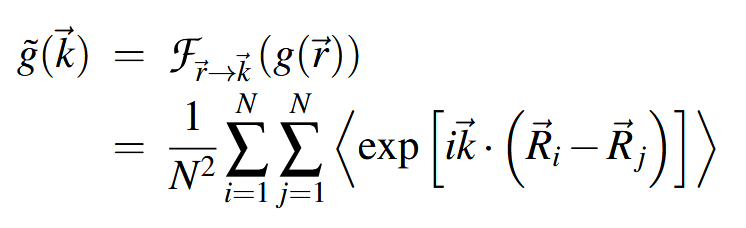


    a) Laplace inversion of wlc Green's function in Fourier-Laplace space (wlcstat doc)
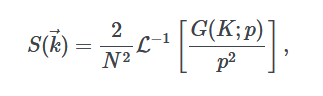
    


2) I_s(q) / I_s(q=0) (466 Lec 7, Rubinstein 2.8.2)
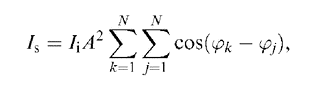
 
### Why it matters:

 "correlating scattering experiments with theoretical models provides insight into the physical behavior in polymeric fluids"
 
 generally, can tell error in [R_ij] -> at small scattering wavevector q, can compare <R_g^2>
 
 Experimentally verify theory polymer behavior in presence of different solvents

Fundamentally, any structure facot is essentially letting you know about how densities correlate
AB structure factor- at some position with vol frac A, what is the probability of vol frac B a certain distance away

#### meaning of single-chain?
Experimental result is a summation of monomer on a chain- makes sense

Analytical result (at small q) averaging over ensemble? single chain != in isolation?

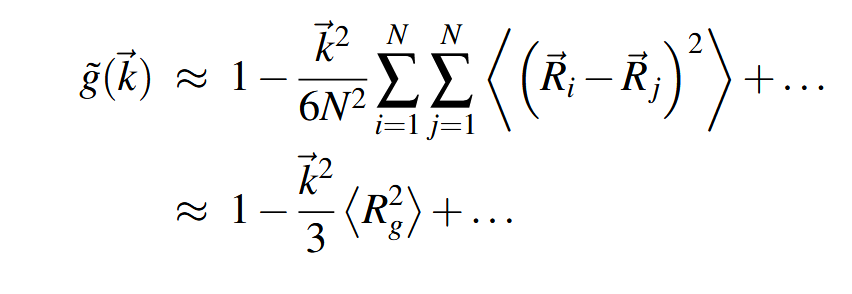



#### How does solvent enviroment impact these results?

structure factor essentially only depends on chain conformation and scattering wavevector


but, for the analytical solution, introducing interactions (bead-bead, bead-solvent) would change polymer conformations


Are these interactions considered in the evaluation of structure factor? (quasi-chemical solution model

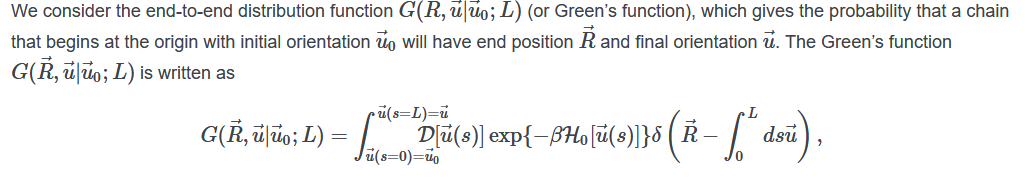

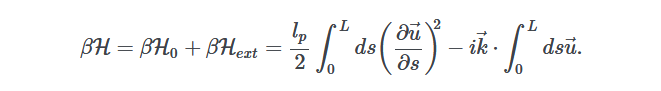

In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import wlcave as wlcave #need to path correctly!
import matplotlib.cm as cm
import sys
from wlcstat.wlcstruc import *
import itertools

#for data processing
import os
import operator
import xlrd

C:\Users\tmhab\AppData\Roaming\Python\Python37\site-packages\numpy\core\getlimits.py:172: RuntimeWarning: divide by zero encountered in exp2
  eps=exp2(ld(-112)),
C:\Users\tmhab\AppData\Roaming\Python\Python37\site-packages\numpy\core\getlimits.py:51: RuntimeWarning: divide by zero encountered in log10
  self.precision = int(-log10(self.eps))
C:\Users\tmhab\AppData\Roaming\Python\Python37\site-packages\numpy\core\getlimits.py:52: RuntimeWarning: divide by zero encountered in power
  self.resolution = float_to_float(float_conv(10) ** (-self.precision))
C:\Users\tmhab\AppData\Roaming\Python\Python37\site-packages\numpy\core\getlimits.py:184: RuntimeWarning: divide by zero encountered in exp2
  epsneg_f80 = exp2(ld(-64))
C:\Users\tmhab\AppData\Roaming\Python\Python37\site-packages\numpy\core\getlimits.py:185: RuntimeWarning: divide by zero encountered in exp2
  tiny_f80 = exp2(ld(-16382))
C:\Users\tmhab\AppData\Roaming\Python\Python37\site-packages\numpy\core\getlimits.py:199: RuntimeWarn

In [7]:
#np.show_config()

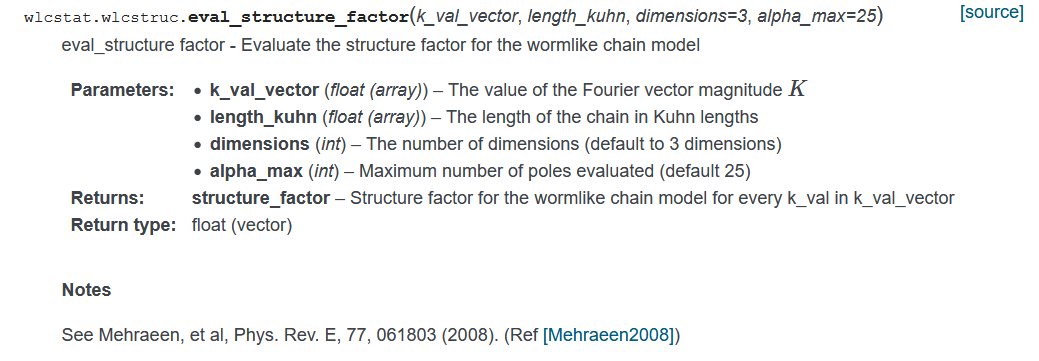

Scattering vector = scattering wave vector = q = k

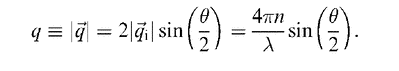

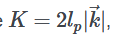

Two appraoches: 

- Fourier transform of pair correlation function
- Ratio of I_scattered(q) / I_scattered(q=0)

### Simulation Solution:

#### ABmelt:

In [624]:
chi_zero_1_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.13.21_ABmelt_fully_reproduced_shorter_range_96hrs_OLD/all_rs/r50v1"
chi_zero_2_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_72hrs_OLD/all_rs/r39v1"
chi_zero_3_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_160hrs_OLD/all_rs/r92v1"
chi_zero_4_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_96hrs_OLD/all_rs/r49v1"
chi_zero_5_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_120hrs_OLD/all_rs/r64v1"
name_list = ["X", "Y", "Z", "Type"] 
chi_zero_1_df = pd.read_csv(chi_zero_1_path, names = name_list, delim_whitespace=True)
chi_zero_2_df = pd.read_csv(chi_zero_2_path, names = name_list, delim_whitespace=True)
chi_zero_3_df = pd.read_csv(chi_zero_3_path, names = name_list, delim_whitespace=True)
chi_zero_4_df = pd.read_csv(chi_zero_4_path, names = name_list, delim_whitespace=True)
chi_zero_5_df = pd.read_csv(chi_zero_5_path, names = name_list, delim_whitespace=True)
chi_zero_list = [chi_zero_1_df, chi_zero_2_df, chi_zero_3_df, chi_zero_4_df, chi_zero_5_df]

macroletters

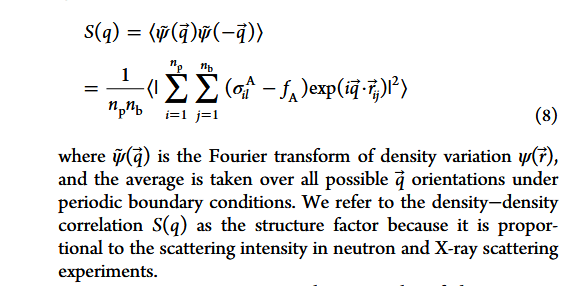

soft matter

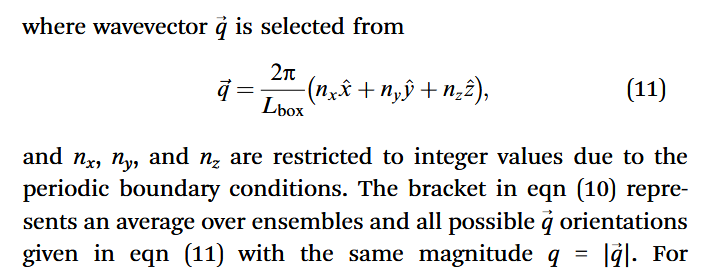

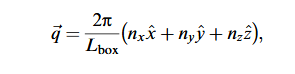

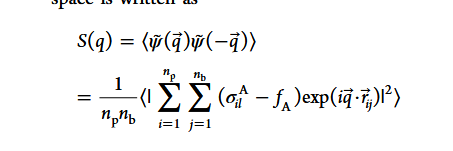

In [625]:
def gen_triples_vector(rnge):
    #to make sute itertools.combinations creates all permutations
    lst = []
    for i in range(rnge):
        lst += ([i]*3)
    return lst

In [626]:
def get_mag_vec_map(rnge, l_box = 20):
    comb_dict = {}
    #gen apropraiate vector
    trips = gen_triples_vector(rnge)
    for comb in itertools.combinations(trips, 3):
        comb = np.array(comb)
        comb_mag = np.linalg.norm(comb* (2*np.pi/l_box))
        # if comb_mag not in dictionary
        if comb_mag not in comb_dict:
            comb = comb * (2*np.pi/l_box)
            permutes = list(itertools.permutations(comb))
            for i in range(len(permutes)):
                #permutes[i] = list(permutes[i])
                permutes[i] = np.array(list(permutes[i]))
            permutes = np.unique(np.array(permutes), axis=0)
            comb_dict[comb_mag] = permutes
    return comb_dict

In [644]:
#want an array of increasing vector magnitudes that maps onto arrays of all vector permutations with that same magnitude

#TO DO
#gaussian smoothing didnt work, so try averaging over ensembles DONE
#also, R_m could be wrong- may need to calculate?
def structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, l_box=20):
    '''
    melt structure factor.  
    q_vectors is a list of vectors with same magnitude
    '''
#     q_vectors= np.array([])    
#     q_mag_squared = ((q*l_box)/(2*np.pi))**2
    
#     if int(q_mag_squared) != q_mag_squared:
#         return None
#     else:
#         q_vectors = find_q_vects((q*l_box)/(2*np.pi))
 
    sum_avg = 0
    #print(np.shape(q_vectors)[0])
    for q_vect in q_vectors:
        q_vect = q_vect * (2*np.pi)/l_box
        summ = 0
        #(A*e^B)
        A = df.Type - f_A
        B = 1j*np.dot(df.iloc[:,:3], q_vect)
        summ = (A*np.exp(B)).sum()            
        sum_avg += (np.absolute(summ)**2)/(np.shape(q_vectors)[0])#q_vectors.size
    return sum_avg * (1/(n_p*n_b))
    

In [645]:
#constants
f_A = 0.5
n_p = 2000
n_b = 40
l_box = 20
# inputs
q=(2*np.pi*3)/l_box

#chi_zero_df
R_m = 2.03 #unperturbed average end-to-end separation of a monomer

In [646]:
mag_vects_map = get_mag_vec_map(20, l_box = 20)
sorted_magnitudes = sorted(mag_vects_map.keys())
structure_fact_array = np.array([])
for mag in sorted_magnitudes:
    q_vectors = mag_vects_map[mag]
    #print(q_vectors)
    sf_average = 0
    for df in chi_zero_list: #avging over ensembles
        sf = structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, l_box=20)
        sf_average += sf/(len(chi_zero_list))
    structure_fact_array = np.append(structure_fact_array, sf_average)


NEW ONE!


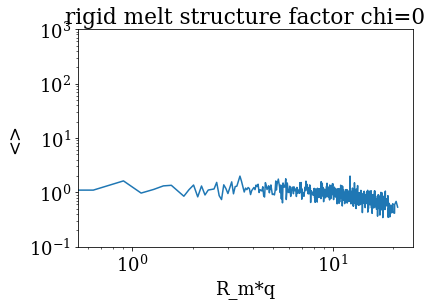

In [647]:
sort_magss = np.array(sorted_magnitudes)
plt.loglog(sort_magss*R_m, structure_fact_array)
plt.title("rigid melt structure factor chi=0")
plt.xlabel("R_m*q")
plt.ylabel("<>")
plt.ylim((10**-1, 10**3))
print("NEW ONE!")

In [2]:

# num_k = 100
# k_val_0 = 1e-2
# k_val_f = 20
# length_kuhn_vec = np.array([0.1, 0.5, 1])
dimensions = 3

# plt.figure(figsize=(10,8))
# font = {'family' : 'serif',
#     'weight':'normal',
#     'size': 18}
# plt.rc('font', **font)


length_kuhn = 2.03
k_val = sort_magss
structure_factor = eval_structure_factor(k_val, length_kuhn, dimensions)
plt.plot(k_val * length_kuhn, np.real(structure_factor * k_val * length_kuhn),'-')

plt.xlabel(r'$Lk$')
plt.ylabel(r'Structure Factor, $k L S(K;N)$')
# plt.ylim((2, 3.5))
# plt.xlim((2, 20))
# plt.tight_layout()
plt.show()

NameError: name 'sort_magss' is not defined

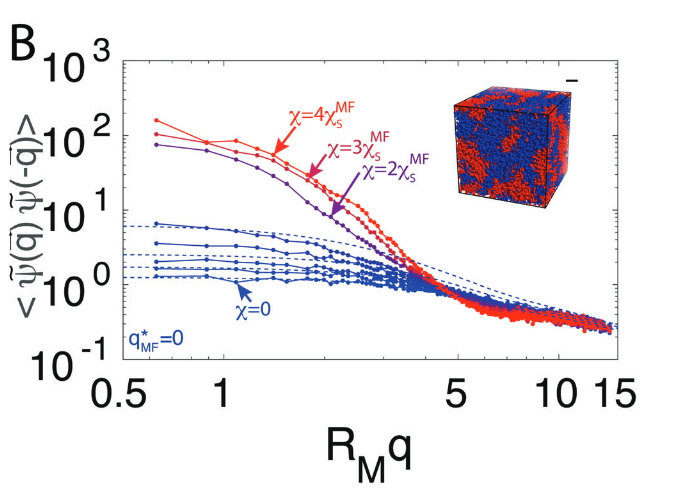

In [636]:
# y_vals = structure_fact_array
# x_vals = sort_magss*R_m
# sigma = 0.45 #paper- std dv = 0.45

# smoothed_vals = np.zeros(len(y_vals)+1)
# for i, x_val in enumerate(x_vals):
#     kernel = np.exp(-(x_vals - x_val) ** 2 / (2 * sigma ** 2)) #gaussian centerd at each point
#     kernel = kernel / sum(kernel) #normalize
#     smoothed_vals[i] = sum(y_vals * kernel)
    

In [638]:
# plt.loglog(x_vals, smoothed_vals[1:], color= "tab:orange")
# plt.ylim((10**-1, 10**3))

In [ ]:
#reproduce 2017 soft matter structuer factor plot
# edit fucntion for ab solution
# use on new data!!

### Analytical Solution:

In [5]:
np.version.version

'1.20.3'

In [4]:
D = np.diag((-1,1))
M = [[-1, 0],[0, 1]]
np.linalg.eig(M)

LinAlgError: Eigenvalues did not converge

In [3]:
# example run
num_k = 100
k_val_0 = 1e-2
k_val_f = 20
length_kuhn_vec = np.array([0.1, 0.5, 1])
dimensions = 3

plt.figure(figsize=(10,8))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

for ind_length in range(0, len(length_kuhn_vec)):
    length_kuhn = float(length_kuhn_vec[ind_length])
    k_val = np.linspace(k_val_0, k_val_f / length_kuhn, num_k)
    structure_factor = eval_structure_factor(k_val, length_kuhn, dimensions)
    plt.plot(k_val * length_kuhn, np.real(structure_factor * k_val * length_kuhn),'-')

plt.xlabel(r'$Lk$')
plt.ylabel(r'Structure Factor, $k L S(K;N)$')
plt.ylim((2, 3.5))
plt.xlim((2, 20))
plt.tight_layout()
plt.show()

LinAlgError: Eigenvalues did not converge

<Figure size 720x576 with 0 Axes>

In [ ]:
num_k = 100
k_val_0 = 1e-1
k_val_f = 1e3
k_val = np.logspace(np.log10(k_val_0), np.log10(k_val_f), num_k)
mu=0
dimensions = 3
num_poles = min(12, 26-mu)
poles = np.zeros((num_k, num_poles), dtype=type(1 + 1j))
for i_k_val in range(num_k):
    poles_k_val = eval_poles(k_val[i_k_val], mu, dimensions)
    resi_k_val = eval_residues(k_val[i_k_val], mu, poles, True, dimensions)
    #poles_k_val, resi_k_val = eval_poles_and_residues(k_val[i_k_val],mu,dimensions)
    for i_pole in range(num_poles):
        poles[i_k_val, i_pole] = poles_k_val[i_pole]

plt.figure(figsize=(10,8))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

for i_pole in range(num_poles):
    plt.semilogx(k_val, np.real(poles[:, i_pole]))

plt.xlabel(r'$K = (2l_{p}) k$')
plt.ylabel(r'Real ($\mathcal{E}_{\alpha}$)')
plt.tight_layout()
plt.show()

In [399]:
# Bead vector itself is the sigma values!
# def sigma(bead_type, comp_type):
#     if bead_type == comp_type:
#         return 1
#     elif bead_type != comp_type:
#         return 0

In [593]:
# #testing if [0,0,1] has same magnitude as [0, 0, -1] .if same mag, shouldnt matter. THEY DO HAVE SAME MAGNITUDE
# A_test = chi_zero_df.Type - 0.5
# B_pos = 1j*np.dot(chi_zero_df.iloc[:,:3], np.array([0, 0, 1]))
# B_neg =  1j*np.dot(chi_zero_df.iloc[:,:3], np.array([0, 0, -1]))

# summ_neg = (A_test*np.exp(B_neg)).sum()
# print(np.absolute(summ_neg))

# summ_pos = (A_test*np.exp(B_pos)).sum()
# print(np.absolute(summ_pos))

In [312]:
# def find_q_vects(q_magnitude):
#     '''
#     already multiplied by L_box and 2pi
#     '''
#     x_arr = np.arange(np.ceil(q_magnitude)+1)
#     y_arr = np.arange(np.ceil(q_magnitude)+1)
#     z_arr = np.arange(np.ceil(q_magnitude)+1)
#     q_init = np.array([])
#     q_failed_init = np.array([])
#     q_init = find_q_vects_rec(q_magnitude, q_init, q_failed_init, x_arr, y_arr, z_arr)
#     return q_init
    
# def find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem, z_arr_rem):
#     #print("before running, q_correct is:", q_correct)
#     if x_arr_rem.size == 0 and y_arr_rem.size == 0 and z_arr_rem.size == 0:
#         #stopping condition
#         return q_correct
#     else:
#         if x_arr_rem.size==0:
#             x = np.ceil(q_magnitude)
#         else:
#             x = x_arr_rem[0]
            
#         if y_arr_rem.size==0:
#             y = np.ceil(q_magnitude)
#         else:
#             y = y_arr_rem[0]
        
#         if z_arr_rem.size==0:
#             z = np.ceil(q_magnitude)
#         else:
#             z = z_arr_rem[0] 
        
#         pos_vect = np.array([x, y, z])
#         #print("-----------------")
#         #print("pos_vect is:", pos_vect)
#         #print("q_correct is:", q_correct)
#         #print("q_failed is:", q_failed)
#         #determine if any permutation of this vector have already been 
#         permutes = list(itertools.permutations(pos_vect))
#         for i in range(len(permutes)):
#             permutes[i] = list(permutes[i])
#         permutes = np.array(permutes)
        
#         for perm in permutes:
#             #print("one permutation is:", perm)
            
#             perm_in_q = False
#             perm_in_qf = False
#             for q in q_correct:
#                 if np.all([q, perm]):
#                     perm_in_q = True
#                     break
#             for q in q_failed:
#                 if np.all([q, perm]):       
                    
#             if perm_in_q:
#             #if perm in q_correct: #already found a permutation works
#                 #print("ALREADY DONE")
#                 #next recursive step NECESSARY BUT WHY
#                 #q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem, z_arr_rem[1:])
#                 #q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem[1:], z_arr_rem)
#                 #q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem[1:], y_arr_rem, z_arr_rem)

#                 return q_correct
#              elif perm in q_failed:
# #                 print(perm in q_failed)
# #                 #already found a permutation failed
# #                 print("already failed!!!")
# #                 return q_correct
#         #print("mag is:", np.linalg.norm(pos_vect))
#         if np.linalg.norm(pos_vect) == q_magnitude:
#             #print("is good!")
#             if q_correct.size == 0:
#                 q_correct = np.array([pos_vect])
#             else:
#                 q_correct = np.append(q_correct, [pos_vect], axis=0)
            
#             #next recursive step
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem, z_arr_rem[1:])
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem[1:], z_arr_rem)
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem[1:], y_arr_rem, z_arr_rem)
            
#             return q_correct

#         else:
#             if q_failed.size == 0:
#                 q_failed = np.array([pos_vect])
#             else:
#                 q_failed = np.append(q_failed, [pos_vect], axis=0)
            

#             #next recursive step
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem, z_arr_rem[1:])
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem[1:], z_arr_rem)
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem[1:], y_arr_rem, z_arr_rem)
            
#             return q_correct
        
#     return q_correct

